In [1]:
# imports 
import numpy as np 
import pandas as pd 
import h5py
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
from matplotlib_venn import venn3
import matplotlib.colors as mcolors
import warnings
import pingouin as pg
import seaborn as sns
import glob
import os
import h5_utilities_module as h5u

In [2]:
def find_candidate_states(indata, n_classes, temporal_thresh, mag_thresh):
    """Finds periods where decoded posteriors are twice their noise level.

    Args:
        indata (ndarray): 2d array of posterior probabilities associated with some decoder output.
        n_classes (int): How many classes were used in the decoder?
        temporal_thresh (int): Number of contiguous samples that must be above a threshold to be a real state (typically 2).
        mag_thresh (flat): how many times the noise level must a state be? (e.g. 2 = twice the noise level)

    Returns:
        state_details (ndarray): 2d array where each row details when a state occurred [trial_num, time_in_trial, state_length, state_magnitude].
        state_array (ndarray): 2d array the same size as indata. It contains 1 in all locations where there were states and 0s everywhere else.
    """
    state_details = np.array([])
    state_array = np.zeros_like(indata)
    
    state_magnitude_thresh = (1 / n_classes) * mag_thresh

    for t in range(indata.shape[0]):
        state_len, state_pos, state_type = find_1dsequences(indata[t, :] > state_magnitude_thresh)
        state_len = state_len[state_type == True]
        state_pos = state_pos[state_type == True]

        for i in range(len(state_len)):
            state_details = np.concatenate((state_details, np.array([t, state_pos[i], state_len[i]])))

    state_details = state_details.reshape(-1, 3)
    state_details = state_details[state_details[:, 2] > temporal_thresh, :]

    # Update state_array using state_details information
    for j in range(len(state_details)):
        state_trial, state_start, state_len = state_details[j].astype(int)
        state_array[state_trial, state_start:(state_start + state_len)] = 1
        
    new_state_details = get_state_magnitudes(state_details, indata)

    return new_state_details, state_array


def get_state_magnitudes(state_details, indata):
    """This is a helpfer function for find_candidate_states that computes the magnitude of each candidate state. 

    Args:
        state_details (ndarray): 2d array where each row details when a state occurred [trial_num, time_in_trial, state_length].
        indata (ndarray): 2d array of posterior probabilities associated with some decoder output.

    Returns:
        new_state_details (ndarray): 2d array where each row details when a state occurred [trial_num, time_in_trial, state_length, state_magnitude].
    """
    
    new_state_details = np.zeros((len(state_details), 4))
    
    # loop over each state
    for i in range(len(state_details)):
        
        # pull the details of this particular state
        i_trial_num = int(state_details[i, 0])
        i_start_ix = int(state_details[i, 1])
        i_duration = int(state_details[i, 2])
        
        new_state_details[i, 0] = i_trial_num
        new_state_details[i, 1] = i_start_ix
        new_state_details[i, 2] = i_duration

        new_state_details[i, 3] = np.nanmean(indata[i_trial_num, i_start_ix:i_start_ix+i_duration])
        
    return new_state_details
        

def find_1dsequences(inarray):
        ''' 
        run length encoding. Partial credit to R rle function. 
        Multi datatype arrays catered for including non Numpy
        returns: tuple (runlengths, startpositions, values) 
        '''
        ia = np.asarray(inarray)                # force numpy
        n = len(ia)
        if n == 0: 
            return (None, None, None)
        else:
            y = ia[1:] != ia[:-1]                 # pairwise unequal (string safe)
            i = np.append(np.where(y), n - 1)     # must include last element 
            lens = np.diff(np.append(-1, i))      # run lengths
            pos = np.cumsum(np.append(0, lens))[:-1] # positions
            return(lens, pos, ia[i])
        
def moving_average(x, w, axis=0):
    '''
    Moving average function that operates along specified dimensions of a NumPy array.

    Parameters:
    - x (numpy.ndarray): Input array.
    - w (int): Size of the window to convolve the array with (i.e., smoothness factor).
    - axis (int): Axis along which to perform the moving average (default is 0).

    Returns:
    - numpy.ndarray: Smoothed array along the specified axis with the same size as the input array.
    '''
    x = np.asarray(x)  # Ensure input is a NumPy array
    if np.isnan(x).any():
        x = np.nan_to_num(x)  # Replace NaN values with zeros

    if axis < 0:
        axis += x.ndim  # Adjust negative axis value

    kernel = np.ones(w) / w  # Create kernel for moving average

    # Pad the array before applying convolution
    pad_width = [(0, 0)] * x.ndim  # Initialize padding for each axis
    pad_width[axis] = (w - 1, 0)  # Pad along the specified axis (left side)
    x_padded = np.pad(x, pad_width, mode='constant', constant_values=0)

    # Apply 1D convolution along the specified axis on the padded array
    return np.apply_along_axis(lambda m: np.convolve(m, kernel, mode='valid'), axis, x_padded)

def calculate_mean_and_interval(data, type='sem', num_samples=1000, alpha=0.05):
    """
    Calculate mean and either SEM or bootstrapped CI for each column of the input array, disregarding NaN values.

    Parameters:
    - data: 2D numpy array
    - type: str, either 'sem' or 'bootstrap_ci'
    - num_samples: int, number of bootstrap samples (applicable only for type='bootstrap_ci')
    - alpha: float, significance level for the confidence interval (applicable only for type='bootstrap_ci')

    Returns:
    - means: 1D numpy array containing means for each column
    - interval: 1D numpy array containing SEMs or bootstrapped CIs for each column
    """
    nan_mask = ~np.isnan(data)
    
    nanmean_result = np.nanmean(data, axis=0)
    n_valid_values = np.sum(nan_mask, axis=0)
    
    if type == 'sem':
        nanstd_result = np.nanstd(data, axis=0)
        interval = nanstd_result / np.sqrt(n_valid_values)
        
    elif type == 'percentile':
        interval = np.mean(np.array([np.abs(nanmean_result - np.nanpercentile (data, 5, axis=0)), np.abs(nanmean_result - np.nanpercentile (data, 95, axis=0))]))
        
        
    elif type == 'bootstrap':
        n_rows, n_cols = data.shape

        # Initialize array to store bootstrap means
        bootstrap_means = np.zeros((num_samples, n_cols))

        # Perform bootstrap resampling for each column
        for col in range(n_cols):
            
            if np.sum(nan_mask[:, col]) > 0:
                bootstrap_samples = np.random.choice(data[:, col][nan_mask[:, col]], size=(num_samples, n_rows), replace=True)
                bootstrap_means[:, col] = np.nanmean(bootstrap_samples, axis=1)
            else:
                bootstrap_means[:, col] = np.nan

        # Calculate confidence interval bounds
        ci_lower = np.percentile(bootstrap_means, 100 * (alpha / 2), axis=0)
        ci_upper = np.percentile(bootstrap_means, 100 * (1 - alpha / 2), axis=0)
        
        interval = np.nanmean([abs(bootstrap_means - ci_lower), abs(bootstrap_means - ci_upper)], axis=0)
        
        interval = np.nanmean(interval, axis=0)

    else:
        raise ValueError("Invalid 'type' argument. Use either 'sem' or 'bootstrap'.")
    
    return nanmean_result, interval


In [3]:
# where are the data?
data_dir = 'C:/Users/thome/Documents/PYTHON/Self-Control/decoder_output/'

# get their relevant paths
data_files = h5u.find_h5_files(data_dir)

In [4]:
# initialize lists to accumulate data into
OFC_ch = []
OFC_unch = []
OFC_alt_ch = []
OFC_alt_unch = []
CdN_ch = []
CdN_unch = []
CdN_alt_ch = []
CdN_alt_unch = []
bhv = pd.DataFrame()
OFC_acc = []
CdN_acc = []
subject = []
session = []
OFC_pp = []
CdN_pp = []


# accumulate data from each file

for f_num, this_file in enumerate(data_files):
    
    if 'D' in Path(this_file).stem:
        s = 0
    else:
        s = 1
            
    # Append the data to the lists
    subject.append(np.ones(len(h5u.pull_from_h5(this_file, 'OFC_acc_mean')), )*s)
    session.append(np.ones(len(h5u.pull_from_h5(this_file, 'OFC_acc_mean')), )*f_num)

    bhv = pd.concat([bhv, pd.read_hdf(this_file, key='bhv')], ignore_index=True)
    
    OFC_ch.append(h5u.pull_from_h5(this_file, 'OFC_ch'))
    OFC_unch.append(h5u.pull_from_h5(this_file, 'OFC_unch'))
    OFC_alt_ch.append(h5u.pull_from_h5(this_file, 'OFC_alt_ch'))
    OFC_alt_unch.append(h5u.pull_from_h5(this_file, 'OFC_alt_unch'))
    
    CdN_ch.append(h5u.pull_from_h5(this_file, 'CdN_ch'))
    CdN_unch.append(h5u.pull_from_h5(this_file, 'CdN_unch'))
    CdN_alt_ch.append(h5u.pull_from_h5(this_file, 'CdN_alt_ch'))
    CdN_alt_unch.append(h5u.pull_from_h5(this_file, 'CdN_alt_unch'))
    
    OFC_acc.append(h5u.pull_from_h5(this_file, 'OFC_acc_mean'))
    CdN_acc.append(h5u.pull_from_h5(this_file, 'CdN_acc_mean'))
    
    ts = h5u.pull_from_h5(this_file, 'ts')
    
    # pull the posteriors
    OFC_pp.append(h5u.pull_from_h5(this_file, 'OFC_pp'))
    CdN_pp.append(h5u.pull_from_h5(this_file, 'CdN_pp'))
    


# convert everything back to arrays
subject = np.concatenate(subject, axis=0)
session = np.concatenate(session, axis=0)

OFC_ch = np.concatenate(OFC_ch, axis=0)
OFC_unch = np.concatenate(OFC_unch, axis=0)
OFC_alt_ch = np.concatenate(OFC_alt_ch, axis=0)
OFC_alt_unch = np.concatenate(OFC_alt_unch, axis=0)

CdN_ch = np.concatenate(CdN_ch, axis=0)
CdN_unch = np.concatenate(CdN_unch, axis=0)
CdN_alt_ch = np.concatenate(CdN_alt_ch, axis=0)
CdN_alt_unch = np.concatenate(CdN_alt_unch, axis=0)

OFC_acc = np.concatenate(OFC_acc, axis=0)
CdN_acc = np.concatenate(CdN_acc, axis=0)

OFC_pp = np.concatenate(OFC_pp, axis=0)
CdN_pp = np.concatenate(CdN_pp, axis=0)


In [5]:
long_double_take = (bhv['sacc2_t'] - bhv['sacc1_t']) > 100
stateAB_single_take_trials = np.argwhere((bhv['n_sacc'] == 1) & (bhv['state'] < 3) & (bhv['picked_best'] == 1)).flatten()
stateAB_double_take_trials = np.argwhere((bhv['n_sacc'] == 2) & (bhv['state'] < 3) & (bhv['picked_best'] == 1) & (long_double_take)).flatten()

In [6]:
# find the predicted label for each moment in each trial
ofc_predicted_valstate = np.argmax(OFC_pp, axis = 2)
ofc_predicted_state = np.where(ofc_predicted_valstate <= 3, 1, 
                         np.where(ofc_predicted_valstate <= 7, 2, 3))

cdn_predicted_valstate = np.argmax(CdN_pp, axis = 2)
cdn_predicted_state = np.where(cdn_predicted_valstate <= 3, 1, 
                         np.where(cdn_predicted_valstate <= 7, 2, 3))

ofc_val_state_pp = np.zeros((len(bhv), len(ts), 3))
ofc_val_state_pp[:,:, 0] = np.nanmean(OFC_pp[:,:, 0:4], axis=2)
ofc_val_state_pp[:,:, 1] = np.nanmean(OFC_pp[:,:, 4:8], axis=2)
ofc_val_state_pp[:,:, 2] = np.nanmean(OFC_pp[:,:, 8:12], axis=2)

cdn_val_state_pp = np.zeros((len(bhv), len(ts), 3))
cdn_val_state_pp[:,:, 0] = np.nanmean(CdN_pp[:,:, 0:4], axis=2)
cdn_val_state_pp[:,:, 1] = np.nanmean(CdN_pp[:,:, 4:8], axis=2)
cdn_val_state_pp[:,:, 2] = np.nanmean(CdN_pp[:,:, 8:12], axis=2)

ofc_true_state_pp = np.zeros((len(bhv), len(ts)))
ofc_alt_state_pp = np.zeros((len(bhv), len(ts)))
ofc_other_state_pp = np.zeros((len(bhv), len(ts)))

cdn_true_state_pp = np.zeros((len(bhv), len(ts)))
cdn_alt_state_pp = np.zeros((len(bhv), len(ts)))
cdn_other_state_pp = np.zeros((len(bhv), len(ts)))


# let's create some true, alt, and other state arrays
for t in range(len(bhv)):
    
    t_state = int(bhv['state'].iloc[t])
    
    ofc_true_state_pp[t, :] = ofc_val_state_pp[t, :, t_state - 1]
    cdn_true_state_pp[t, :] = cdn_val_state_pp[t, :, t_state - 1]

    
    if t_state == 1:
        alt_state = 2
    else: 
        alt_state = 1
        
    ofc_alt_state_pp[t, :] = ofc_val_state_pp[t, :, alt_state - 1]
    cdn_alt_state_pp[t, :] = cdn_val_state_pp[t, :, alt_state - 1]

C:\Users\thome\AppData\Local\Temp\ipykernel_8740\3965626627.py:11: RuntimeWarning: Mean of empty slice
  ofc_val_state_pp[:,:, 0] = np.nanmean(OFC_pp[:,:, 0:4], axis=2)
C:\Users\thome\AppData\Local\Temp\ipykernel_8740\3965626627.py:12: RuntimeWarning: Mean of empty slice
  ofc_val_state_pp[:,:, 1] = np.nanmean(OFC_pp[:,:, 4:8], axis=2)
C:\Users\thome\AppData\Local\Temp\ipykernel_8740\3965626627.py:13: RuntimeWarning: Mean of empty slice
  ofc_val_state_pp[:,:, 2] = np.nanmean(OFC_pp[:,:, 8:12], axis=2)
C:\Users\thome\AppData\Local\Temp\ipykernel_8740\3965626627.py:16: RuntimeWarning: Mean of empty slice
  cdn_val_state_pp[:,:, 0] = np.nanmean(CdN_pp[:,:, 0:4], axis=2)
C:\Users\thome\AppData\Local\Temp\ipykernel_8740\3965626627.py:17: RuntimeWarning: Mean of empty slice
  cdn_val_state_pp[:,:, 1] = np.nanmean(CdN_pp[:,:, 4:8], axis=2)
C:\Users\thome\AppData\Local\Temp\ipykernel_8740\3965626627.py:18: RuntimeWarning: Mean of empty slice
  cdn_val_state_pp[:,:, 2] = np.nanmean(CdN_pp[:,:,

Text(0, 0.5, 'Absolute State Mismatch')

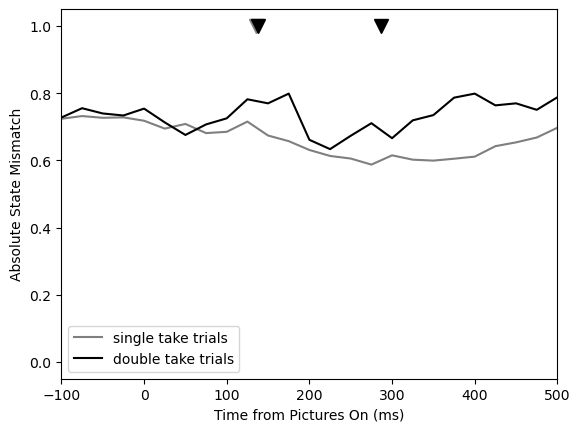

In [7]:
state_mismatch = np.abs(cdn_predicted_state - ofc_predicted_state)

plt.plot(ts, np.mean(state_mismatch[stateAB_single_take_trials, :], axis=0), c = 'tab:gray', label='single take trials')
plt.plot(ts, np.mean(state_mismatch[stateAB_double_take_trials, :], axis=0), c = 'black', label='double take trials')
plt.plot(np.mean(bhv['sacc1_t'].iloc[stateAB_single_take_trials]), 1, marker='v', markersize = 10, c = 'gray')
plt.plot(np.mean(bhv['sacc1_t'].iloc[stateAB_double_take_trials]), 1, marker='v', markersize = 10, c = 'black')
plt.plot(np.mean(bhv['sacc2_t'].iloc[stateAB_double_take_trials]), 1, marker='v', markersize = 10, c = 'black')
plt.legend(loc='lower left')

plt.xlim((-100, 500))
plt.xlabel('Time from Pictures On (ms)')
plt.ylabel('Absolute State Mismatch')

Text(0.5, 1.0, 'CdN')

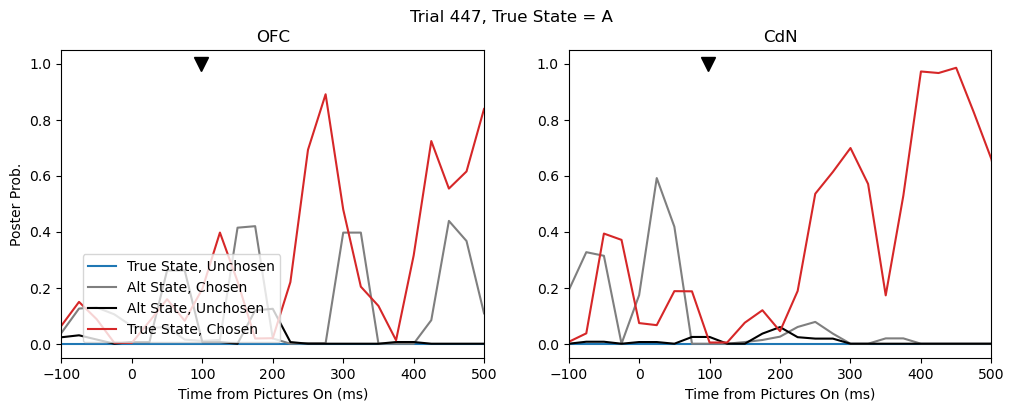

In [8]:
state_list = ['A', 'B', 'C']
ix = 201
trial_num = stateAB_single_take_trials[ix]

fig, ax =plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Trial ' + str(trial_num) + ', True State = ' + state_list[int(bhv['state'].iloc[trial_num]-1)])


ax[0].plot(ts, moving_average(OFC_unch[trial_num, :], 2), c='tab:blue', label = 'True State, Unchosen')
ax[0].plot(ts, moving_average(OFC_alt_ch[trial_num, :], 2), c='tab:gray', label = 'Alt State, Chosen')
ax[0].plot(ts, moving_average(OFC_alt_unch[trial_num, :], 2), c='black', label = 'Alt State, Unchosen')
ax[0].plot(ts, moving_average(OFC_ch[trial_num, :], 2), c='tab:red', label = 'True State, Chosen')
ax[0].plot(bhv['sacc1_t'].iloc[trial_num], 1, marker='v', markersize = 10, c = 'black')
ax[0].plot(bhv['sacc2_t'].iloc[trial_num], 1, marker='v', markersize = 10, c = 'black')
ax[0].set_xlim((-100, 500))
ax[0].set_xlabel('Time from Pictures On (ms)')
ax[0].set_ylabel('Poster Prob.')
ax[0].set_title('OFC')
ax[0].legend(loc="lower left", bbox_to_anchor=(.05, .05), borderaxespad=0.)


ax[1].plot(ts, moving_average(CdN_unch[trial_num, :], 2), c='tab:blue', label = 'True State, Unchosen')
ax[1].plot(ts, moving_average(CdN_alt_ch[trial_num, :], 2), c='tab:gray', label = 'Alt State, Chosen')
ax[1].plot(ts, moving_average(CdN_alt_unch[trial_num, :], 2), c='black', label = 'Alt State, Unchosen')
ax[1].plot(ts, moving_average(CdN_ch[trial_num, :], 2), c='tab:red', label = 'True State, Chosen')
ax[1].plot(bhv['sacc1_t'].iloc[trial_num], 1, marker='v', markersize = 10, c = 'black')
ax[1].plot(bhv['sacc2_t'].iloc[trial_num], 1, marker='v', markersize = 10, c = 'black')
ax[1].set_xlim((-100, 500))
ax[1].set_xlabel('Time from Pictures On (ms)')
ax[1].set_title('CdN')

In [135]:
# identify the states based on these criteria
mag_thresh = 2 # how many times above the noise a state must be
time_thresh = 2 # how many consecutive time bins must the state be above that noise-multiple threshold?
n_classes = 12

ofc_ch_details, ofc_ch_states = find_candidate_states(OFC_ch, n_classes, time_thresh, mag_thresh)
ofc_unch_details, ofc_unch_states  = find_candidate_states(OFC_unch, n_classes, time_thresh, mag_thresh)
ofc_alt_ch_details, ofc_alt_ch_states  = find_candidate_states(OFC_alt_ch, n_classes, time_thresh, mag_thresh)
ofc_alt_unch_details, ofc_alt_unch_states  = find_candidate_states(OFC_alt_unch, n_classes, time_thresh, mag_thresh)

cdn_ch_details, cdn_ch_states = find_candidate_states(CdN_ch, n_classes, time_thresh, mag_thresh)
cdn_unch_details, cdn_unch_states  = find_candidate_states(CdN_unch, n_classes, time_thresh, mag_thresh)
cdn_alt_ch_details, cdn_alt_ch_states  = find_candidate_states(CdN_alt_ch, n_classes, time_thresh, mag_thresh)
cdn_alt_unch_details, cdn_alt_unch_states  = find_candidate_states(CdN_alt_unch, n_classes, time_thresh, mag_thresh)

In [136]:
# get states during the choice period
t_thresh1 = 40
t_thresh2 = 56

ofc_ch_choice = ofc_ch_details[(ofc_ch_details[:, 1] > t_thresh1) & (ofc_ch_details[:, 1] < t_thresh2)]
ofc_unch_choice = ofc_unch_details[(ofc_unch_details[:, 1] > t_thresh1) & (ofc_unch_details[:, 1] < t_thresh2)]
ofc_alt_ch_choice = ofc_alt_ch_details[(ofc_alt_ch_details[:, 1] > t_thresh1) & (ofc_alt_ch_details[:, 1] < t_thresh2)]
ofc_alt_unch_choice = ofc_alt_unch_details[(ofc_alt_unch_details[:, 1] > t_thresh1) & (ofc_alt_unch_details[:, 1] < t_thresh2)]

cdn_ch_choice = cdn_ch_details[(cdn_ch_details[:, 1] > t_thresh1) & (cdn_ch_details[:, 1] < t_thresh2)]
cdn_unch_choice = cdn_unch_details[(cdn_unch_details[:, 1] > t_thresh1) & (cdn_unch_details[:, 1] < t_thresh2)]
cdn_alt_ch_choice = cdn_alt_ch_details[(cdn_alt_ch_details[:, 1] > t_thresh1) & (cdn_alt_ch_details[:, 1] < t_thresh2)]
cdn_alt_unch_choice = cdn_alt_unch_details[(cdn_alt_unch_details[:, 1] > t_thresh1) & (cdn_alt_unch_details[:, 1] < t_thresh2)]

In [200]:
# find the number of states of each trial per trial

ofc_n_states_per_trial = np.zeros((len(bhv), 4))
cdn_n_states_per_trial = np.zeros((len(bhv), 4))

ofc_state_mag_per_trial = np.zeros((len(bhv), 4))
cdn_state_mag_per_trial = np.zeros((len(bhv), 4))

for t in range(len(bhv)):
    
    ofc_n_states_per_trial[t, 0] = np.sum(ofc_ch_choice[:, 0] == t)
    ofc_n_states_per_trial[t, 1] = np.sum(ofc_unch_choice[:, 0] == t)
    ofc_n_states_per_trial[t, 2] = np.sum(ofc_alt_ch_choice[:, 0] == t)
    ofc_n_states_per_trial[t, 3] = np.sum(ofc_alt_unch_choice[:, 0] == t)
    
    cdn_n_states_per_trial[t, 0] = np.sum(cdn_ch_choice[:, 0] == t)
    cdn_n_states_per_trial[t, 1] = np.sum(cdn_unch_choice[:, 0] == t)
    cdn_n_states_per_trial[t, 2] = np.sum(cdn_alt_ch_choice[:, 0] == t)
    cdn_n_states_per_trial[t, 3] = np.sum(cdn_alt_unch_choice[:, 0] == t)
    
    ofc_state_mag_per_trial[t, 0] = np.nanmean(ofc_ch_choice[ofc_ch_choice[:, 0] == t, 3])
    ofc_state_mag_per_trial[t, 1] = np.nanmean(ofc_unch_choice[ofc_unch_choice[:, 0] == t, 3])
    ofc_state_mag_per_trial[t, 2] = np.nanmean(ofc_alt_ch_choice[ofc_alt_ch_choice[:, 0] == t, 3])
    ofc_state_mag_per_trial[t, 3] = np.nanmean(ofc_alt_unch_choice[ofc_alt_unch_choice[:, 0] == t, 3])
    
    cdn_state_mag_per_trial[t, 0] = np.nanmean(cdn_ch_choice[cdn_ch_choice[:, 0] == t, 3])
    cdn_state_mag_per_trial[t, 1] = np.nanmean(cdn_unch_choice[cdn_unch_choice[:, 0] == t, 3])
    cdn_state_mag_per_trial[t, 2] = np.nanmean(cdn_alt_ch_choice[cdn_alt_ch_choice[:, 0] == t, 3])
    cdn_state_mag_per_trial[t, 3] = np.nanmean(cdn_alt_unch_choice[cdn_alt_unch_choice[:, 0] == t, 3])
    
# ofc_state_mag_per_trial = np.nan_to_num(ofc_state_mag_per_trial, nan=0)
# cdn_state_mag_per_trial = np.nan_to_num(cdn_state_mag_per_trial, nan=0)

C:\Users\thome\AppData\Local\Temp\ipykernel_8740\2291383589.py:21: RuntimeWarning: Mean of empty slice
  ofc_state_mag_per_trial[t, 0] = np.nanmean(ofc_ch_choice[ofc_ch_choice[:, 0] == t, 3])
C:\Users\thome\AppData\Local\Temp\ipykernel_8740\2291383589.py:22: RuntimeWarning: Mean of empty slice
  ofc_state_mag_per_trial[t, 1] = np.nanmean(ofc_unch_choice[ofc_unch_choice[:, 0] == t, 3])
C:\Users\thome\AppData\Local\Temp\ipykernel_8740\2291383589.py:23: RuntimeWarning: Mean of empty slice
  ofc_state_mag_per_trial[t, 2] = np.nanmean(ofc_alt_ch_choice[ofc_alt_ch_choice[:, 0] == t, 3])
C:\Users\thome\AppData\Local\Temp\ipykernel_8740\2291383589.py:24: RuntimeWarning: Mean of empty slice
  ofc_state_mag_per_trial[t, 3] = np.nanmean(ofc_alt_unch_choice[ofc_alt_unch_choice[:, 0] == t, 3])
C:\Users\thome\AppData\Local\Temp\ipykernel_8740\2291383589.py:26: RuntimeWarning: Mean of empty slice
  cdn_state_mag_per_trial[t, 0] = np.nanmean(cdn_ch_choice[cdn_ch_choice[:, 0] == t, 3])
C:\Users\thome\A

In [202]:

# define some indices to select monkeys and trial types
k_ix = subject == 1
d_ix = subject == 0
AB_single_take_ix = (bhv['n_sacc'] == 1) & (bhv['state'] < 3) & (bhv['picked_best'] == 1)
AB_double_take_ix = (bhv['n_sacc'] == 2) & (bhv['state'] < 3) & (bhv['picked_best'] == 1)

k_ofc_n_single_take = np.nansum(ofc_n_states_per_trial[AB_single_take_ix & k_ix, :], axis=1)
k_ofc_n_double_take = np.nansum(ofc_n_states_per_trial[AB_double_take_ix & k_ix, :], axis=1)
k_ofc_n_states_ttest = pg.ttest(k_ofc_n_single_take, k_ofc_n_double_take, correction=False)

k_cdn_n_single_take = np.nansum(cdn_n_states_per_trial[AB_single_take_ix & k_ix, :], axis=1)
k_cdn_n_double_take = np.nansum(cdn_n_states_per_trial[AB_double_take_ix & k_ix, :], axis=1)
k_cdn_n_states_ttest = pg.ttest(k_cdn_n_single_take, k_cdn_n_double_take, correction=False)

d_ofc_n_single_take = np.nansum(ofc_n_states_per_trial[AB_single_take_ix & d_ix, :], axis=1)
d_ofc_n_double_take = np.nansum(ofc_n_states_per_trial[AB_double_take_ix & d_ix, :], axis=1)
d_ofc_n_states_ttest = pg.ttest(d_ofc_n_single_take, d_ofc_n_double_take, correction=False)

d_cdn_n_single_take = np.nansum(cdn_n_states_per_trial[AB_single_take_ix & d_ix, :], axis=1)
d_cdn_n_double_take = np.nansum(cdn_n_states_per_trial[AB_double_take_ix & d_ix, :], axis=1)
d_cdn_n_states_ttest = pg.ttest(d_cdn_n_single_take, d_cdn_n_double_take, correction=False)


Text(0.5, 1.0, 'Subject D')

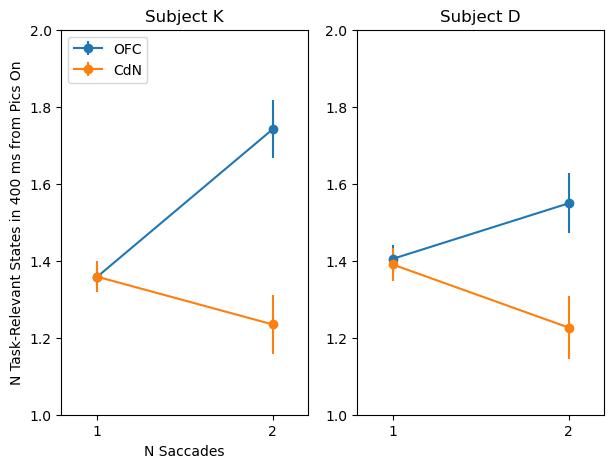

In [203]:
# calculate means and CIs, then plot
k_ofc_single_mean, k_ofc_single_ci = calculate_mean_and_interval(k_ofc_n_single_take.reshape(-1, 1), 'bootstrap')
k_ofc_double_mean, k_ofc_double_ci = calculate_mean_and_interval(k_ofc_n_double_take.reshape(-1, 1), 'bootstrap')
k_cdn_single_mean, k_cdn_single_ci = calculate_mean_and_interval(k_cdn_n_single_take.reshape(-1, 1), 'bootstrap')
k_cdn_double_mean, k_cdn_double_ci = calculate_mean_and_interval(k_cdn_n_double_take.reshape(-1, 1), 'bootstrap')

d_ofc_single_mean, d_ofc_single_ci = calculate_mean_and_interval(d_ofc_n_single_take.reshape(-1, 1), 'bootstrap')
d_ofc_double_mean, d_ofc_double_ci = calculate_mean_and_interval(d_ofc_n_double_take.reshape(-1, 1), 'bootstrap')
d_cdn_single_mean, d_cdn_single_ci = calculate_mean_and_interval(d_cdn_n_single_take.reshape(-1, 1), 'bootstrap')
d_cdn_double_mean, d_cdn_double_ci = calculate_mean_and_interval(d_cdn_n_double_take.reshape(-1, 1), 'bootstrap')

xt = np.arange(2) + 1

k_ofc_means = np.array((k_ofc_single_mean, k_ofc_double_mean)).flatten()
k_ofc_ci = np.array((k_ofc_single_ci, k_ofc_double_ci)).flatten()
k_cdn_means = np.array((k_cdn_single_mean, k_cdn_double_mean)).flatten()
k_cdn_ci = np.array((k_cdn_single_ci, k_cdn_double_ci)).flatten()

d_ofc_means = np.array((d_ofc_single_mean, d_ofc_double_mean)).flatten()
d_ofc_ci = np.array((d_ofc_single_ci, d_ofc_double_ci)).flatten()
d_cdn_means = np.array((d_cdn_single_mean, d_cdn_double_mean)).flatten()
d_cdn_ci = np.array((d_cdn_single_ci, d_cdn_double_ci)).flatten()


# Create the plot
fig, ax = plt.subplots(1, 2, figsize=(7, 5))
ax[0].errorbar(xt, k_ofc_means, k_ofc_ci, marker = 'o', label='OFC')
ax[0].errorbar(xt, k_cdn_means, k_cdn_ci, marker = 'o', label='CdN')
ax[0].set_ylim((1, 2))
ax[0].set_xlim((.8, 2.2))
ax[0].set_xticks((1, 2))
ax[0].set_xlabel('N Saccades')
ax[0].set_ylabel('N Task-Relevant States in 400 ms from Pics On')
ax[0].set_title('Subject K')
ax[0].legend(loc='upper left')


ax[1].errorbar(xt, d_ofc_means, d_ofc_ci, marker = 'o')
ax[1].errorbar(xt, d_cdn_means, d_cdn_ci, marker = 'o')
ax[1].set_ylim((1, 2))
ax[1].set_xlim((.8, 2.2))
ax[1].set_xticks((1, 2))
ax[1].set_title('Subject D')


Text(0.5, 1.0, 'D - CdN')

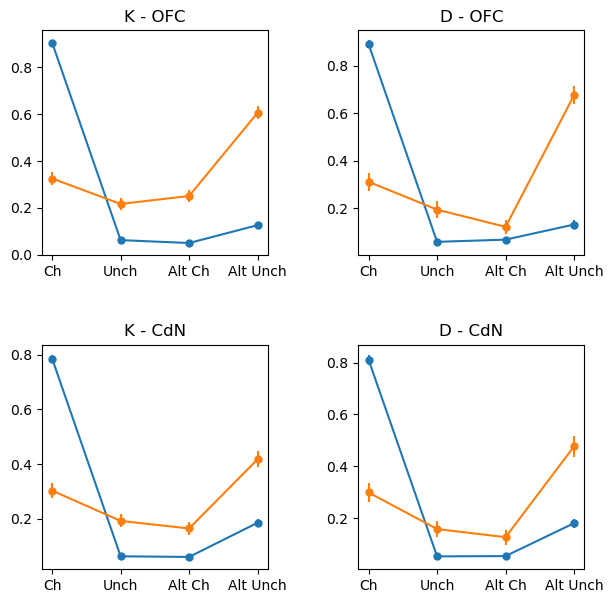

In [205]:
ofc_had_states = ofc_n_states_per_trial > 0
cdn_had_states = cdn_n_states_per_trial > 0


k_ofc_single_types_mean, k_ofc_single_types_ci = calculate_mean_and_interval(ofc_had_states[AB_single_take_ix], 'bootstrap')
k_ofc_double_types_mean, k_ofc_double_types_ci = calculate_mean_and_interval(ofc_had_states[AB_double_take_ix], 'bootstrap')
k_cdn_single_types_mean, k_cdn_single_types_ci = calculate_mean_and_interval(cdn_had_states[AB_single_take_ix], 'bootstrap')
k_cdn_double_types_mean, k_cdn_double_types_ci = calculate_mean_and_interval(cdn_had_states[AB_double_take_ix], 'bootstrap')

d_ofc_single_types_mean, d_ofc_single_types_ci = calculate_mean_and_interval(ofc_had_states[AB_single_take_ix & d_ix], 'bootstrap')
d_ofc_double_types_mean, d_ofc_double_types_ci = calculate_mean_and_interval(ofc_had_states[AB_double_take_ix & d_ix], 'bootstrap')
d_cdn_single_types_mean, d_cdn_single_types_ci = calculate_mean_and_interval(cdn_had_states[AB_single_take_ix & d_ix], 'bootstrap')
d_cdn_double_types_mean, d_cdn_double_types_ci = calculate_mean_and_interval(cdn_had_states[AB_double_take_ix & d_ix], 'bootstrap')

# Create the plot
fig, ax = plt.subplots(2, 2, figsize=(7, 7))
plt.subplots_adjust(wspace=0.4, hspace=0.4)  # add some white space

xlabels = ['Ch', 'Unch', 'Alt Ch', 'Alt Unch']
xt = np.arange(4)

ax[0,0].errorbar(xt, k_ofc_single_types_mean, k_ofc_single_types_ci, marker='o', markersize=5)
ax[0,0].errorbar(xt, k_ofc_double_types_mean, k_ofc_double_types_ci, marker='o', markersize=5)
ax[0,0].set_xticks(xt)
ax[0,0].set_xticklabels(xlabels)
ax[0,0].set_title('K - OFC')

ax[0,1].errorbar(xt, d_ofc_single_types_mean, d_ofc_single_types_ci, marker='o', markersize=5)
ax[0,1].errorbar(xt, d_ofc_double_types_mean, d_ofc_double_types_ci, marker='o', markersize=5)
ax[0,1].set_xticks(xt)
ax[0,1].set_xticklabels(xlabels)
ax[0,1].set_title('D - OFC')

ax[1,0].errorbar(xt, k_cdn_single_types_mean, k_cdn_single_types_ci, marker='o', markersize=5)
ax[1,0].errorbar(xt, k_cdn_double_types_mean, k_cdn_double_types_ci, marker='o', markersize=5)
ax[1,0].set_xticks(xt)
ax[1,0].set_xticklabels(xlabels)
ax[1,0].set_title('K - CdN')

ax[1,1].errorbar(xt, d_cdn_single_types_mean, d_cdn_single_types_ci, marker='o', markersize=5)
ax[1,1].errorbar(xt, d_cdn_double_types_mean, d_cdn_double_types_ci, marker='o', markersize=5)
ax[1,1].set_xticks(xt)
ax[1,1].set_xticklabels(xlabels)
ax[1,1].set_title('D - CdN')

In [260]:
cdn_state_mag_by_n_ofc_states = np.zeros((5, 2))
doubletake_likelihood_by_n_ofc_states = np.zeros((5, ))

cdn_mean_mags = np.nanmean(cdn_state_mag_per_trial, axis=1)
ofc_total_states = np.sum(ofc_n_states_per_trial, axis=1)

ttest_results = []

for i in range(len(cdn_state_mag_by_n_ofc_states)):
    
    ix = ofc_total_states == i + 1
    
    cdn_state_mag_by_n_ofc_states[i, 0] = np.nanmean(cdn_mean_mags[ix & AB_single_take_ix])
    cdn_state_mag_by_n_ofc_states[i, 1] = np.nanmean(cdn_mean_mags[ix & AB_double_take_ix])
    ttest_results.append(pg.ttest(cdn_mean_mags[ix & AB_single_take_ix], cdn_mean_mags[ix & AB_double_take_ix]))
    
    doubletake_likelihood_by_n_ofc_states[i] = np.mean(bhv['n_sacc'].iloc[ix] == 2)
    

C:\Users\thome\AppData\Local\Temp\ipykernel_8740\3142837577.py:4: RuntimeWarning: Mean of empty slice
  cdn_mean_mags = np.nanmean(cdn_state_mag_per_trial, axis=1)


Text(0, 0.5, 'Likelihood of Double-Take Occurring')

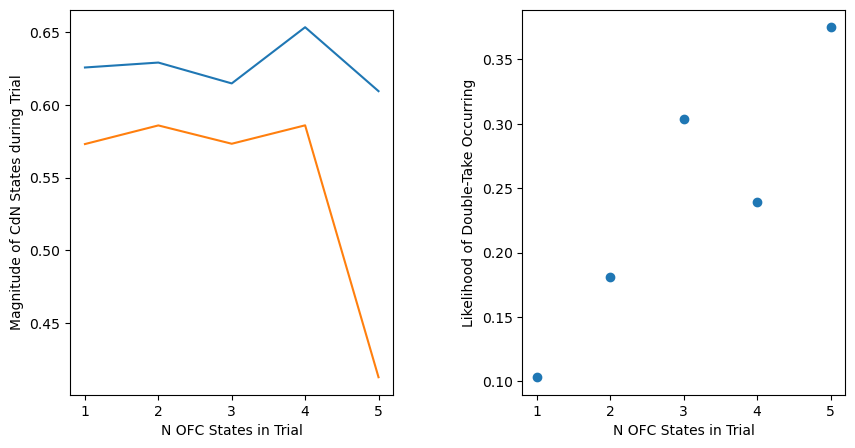

In [261]:
# Create  plot
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plt.subplots_adjust(wspace=0.4, hspace=0.4)  # add some white space
ax[0].plot(np.arange(5)+1, cdn_state_mag_by_n_ofc_states)
ax[0].set_xlabel('N OFC States in Trial')
ax[0].set_ylabel('Magnitude of CdN States during Trial')

ax[1].scatter(np.arange(5)+1, doubletake_likelihood_by_n_ofc_states)
ax[1].set_xlabel('N OFC States in Trial')
ax[1].set_ylabel('Likelihood of Double-Take Occurring')

In [262]:
pg.ttest(cdn_mean_mags[AB_single_take_ix], cdn_mean_mags[AB_double_take_ix])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,8.204766,1273.539894,two-sided,5.598153e-16,"[0.04, 0.06]",0.319324,1.16e+13,1.0
